In [35]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from librosa.core import stft
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
import tensorflow as tf
#import datagen
import soundfile as sf
import os
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression

In [79]:
num_data = 10
samp_length = 8192

X = np.zeros((5000, 25, 257))
A = np.zeros((5000, 8192))
for s in range(0, num_data):
    audio,_ = sf.read('C:/FMSnippets/Samp' + str(s) + '.wav')
    audio = audio.T[0]
    if(audio.shape[0] < samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    else:
        audio = audio[0:samp_length]
    A[s] = audio
    spect = stft(audio, n_fft=128)[0:25,:]
    X[s] = spect

c:\users\joe\summer\synthavinci\env\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


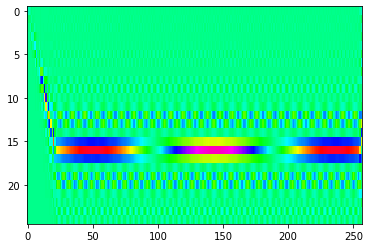

In [80]:


plt.imshow(X[0], aspect='auto', cmap=cm.gist_rainbow)
plt.show()

(128, 17)


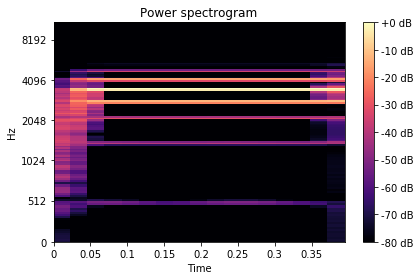

In [85]:
Spectogram = np.abs(librosa.feature.melspectrogram(A[0], sr=44100, n_mels=128))

librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
print(Spectogram.shape)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Load waves and output stft as numpy binary files:

In [6]:
num_data = 50000
samp_length = 8192

for s in range(0, num_data):
    audio,_ = sf.read('/media/data/FMSnippets/samp' + str(s) + '.wav')
    audio = audio.T[0]
    if(audio.shape[0] < samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    else:
        audio = audio[0:samp_length]
    #spect = stft(audio,n_fft=1408)[0:64, 10:11] #Grab from middle of spect, is most regular
    spect = np.abs(librosa.feature.melspectrogram(audio, sr=44100, n_mels=512))[0:512, 10:11]
    np.save('/media/data/FMSpects/spect' + str(s) + '.stft', spect)
        

Generator to load the stft and matrix files in batches:

In [29]:
def dataLoader(batch_size):

    L = 45000
    print(L)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        ymat = np.genfromtxt('/media/data/FMSnippets/mat.txt', delimiter = ',', max_rows=50000)
        while batch_start < L:
            X = np.zeros((batch_size,512,1))
            for i in range (batch_start,batch_end):
                ft = np.load('/home/josephcleveland/FMSpects/spect' + str(i) + '.stft.npy')
                X[i - batch_start] = ft
            Y = ymat[batch_start:batch_end]
            X = np.expand_dims(X, axis = 3)
           # print(Y.shape, " ... ", X.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [4]:
num_data = 45000
samp_length = 8192

Load test data

In [5]:
test_size = 5000
Y_data = np.zeros(shape=(test_size))
mat = np.genfromtxt('/media/data/FMSnippets/mat.txt', delimiter=',')
Y_test = mat[num_data:num_data+test_size]

X_test = np.zeros((test_size,512,1))
for i in range (num_data,num_data+test_size):
    ft = np.load('/media/data/FMSpects/spect' + str(i) + '.stft.npy')
    X_test[i-num_data] = ft

X_test = np.expand_dims(X_test, axis = 3)

In [6]:

def customLoss(yTrue, yPred):
    return K.sum(K.mean(K.square(yTrue[:, 0:2] - yPred[:, 0:2]))) + K.sum(K.mean(K.square(yTrue[:, 2:4] - yPred[:, 2:4]))) * 2 + K.sum(K.mean(K.square(yTrue[:, 4] - yPred[:, 4])))

In [38]:
inputs = Input(shape=(512,1,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = Convolution2D(64, kernel_size=(3, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Flatten()(x)
#x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))(x)
#x = Dense(512, activation='relu')(x)
x = Dense(5)(x)
# This creates a model that includes
# the Input layer and three Dense layers
adam = optimizers.Adam(lr=0.0001)
model = Model(inputs=inputs, outputs=x)
model.compile(adam,
              loss=customLoss,
              metrics=['accuracy'])

In [39]:
fileList = os.listdir('/media/data/FMSpects')

model.fit_generator(dataLoader(32), steps_per_epoch=1406, epochs=40, verbose=1, use_multiprocessing=True)

45000
Epoch 1/40
1406/1406 [==============================] - 19s 14ms/step - loss: 2.0423 - acc: 0.3262
Epoch 2/40
1406/1406 [==============================] - 18s 13ms/step - loss: 1.2180 - acc: 0.4180
Epoch 3/40
1406/1406 [==============================] - 18s 13ms/step - loss: 1.1113 - acc: 0.4773
Epoch 4/40
1406/1406 [==============================] - 18s 13ms/step - loss: 1.0200 - acc: 0.5110
Epoch 5/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.9266 - acc: 0.5339
Epoch 6/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.8285 - acc: 0.5548
Epoch 7/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.7277 - acc: 0.5721
Epoch 8/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.6299 - acc: 0.5852
Epoch 9/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.5421 - acc: 0.5959
Epoch 10/40
1406/1406 [==============================] - 18s 13ms/step - loss: 0.4695 - acc: 0.6053
Epo

In [103]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 512, 1, 1)]       0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 512, 1, 1)         4         
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 256, 1, 1)         0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 256, 1, 64)        256       
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 128, 1, 64)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 128, 1, 128)       24704     
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 64, 1, 128)        0  

In [44]:
o = model.predict(X_test)

In [45]:
model.evaluate(X_test, Y_test)

5000/5000 [==============================] - 1s 106us/sample - loss: 0.1510 - acc: 0.6632


[0.1510250278711319, 0.6632]

In [26]:
audio = wavload.readwav('/Users/josephcleveland/Desktop/Screech.wav')[2]
audio = audio.T[0]

X_audio = audio[0:67584].astype(float)
X_piano = np.zeros((1, 64, 64))
X_piano[0] = stft(X_audio,n_fft=1408)[0:64, 0:64]
X_piano = np.expand_dims(X_piano, axis=3)

Spectogram = np.abs(librosa.feature.melspectrogram(X_audio, sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

o = model.predict(X_piano)

NameError: name 'wavload' is not defined

In [46]:
average_dist = np.zeros(5)

for p in range(0, 5):
    dist_total = 0
    for i in range(0, 5000):
        dist_total += np.absolute(o[i, p] - Y_test[0 + i, p])
    average_dist[p] = dist_total / 5000
    
print(average_dist)
print("average: ", np.average(average_dist))

[0.0564431  0.07393427 0.09406458 0.07158272 0.14716904]
average:  0.08863874263713582


In [41]:
sam = 1
print("predicted", o[sam])
print("original", Y_test[sam])

predicted [0.7553094  0.6772903  0.12203838 0.50940853 0.31881514]
original [0.819 0.724 0.121 0.499 0.278]


In [50]:
np.savetxt("C:/Users/Joe/Summer/Seymour.csv", o, delimiter=",")

In [51]:
# Save the weights
model.save_weights('C:/Users/Joe/Summer/ModelWeights/Seymour.h5')

# Save the model architecture
with open('C:/Users/Joe/Summer/ModelWeights/Seymour.json', 'w') as f:
    f.write(model.to_json())